# Basic Agent Study
Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)

It is recommended to have a look at the [00_introduction](00_Introduction.ipynb), [01_Grid2opFramework](01_Grid2opFramework.ipynb), [02_Observation](02_Observation.ipynb) and [03_Action](03_Action.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will show how to study an Agent. We will use a dummy agent and then look at how to study its behaviour from the saved file.

This notebook will also show you how to use the Graphical User Interface built for analyzing grid2Op agents, called "Grid2Viz".

It is highly recommended to know how to define an Agent and use a Runner before doing this tutorial!

<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">
Execute the cell below by removing the # character if you use google colab !

Cell will look like:
```python
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)
```
<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">

In [1]:
# !pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)

## Evaluate the performance of a simple Agent

In [2]:
import os
import sys
import grid2op
import copy
import numpy as np
import shutil
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from grid2op.Agent import PowerLineSwitch
from grid2op.Reward import L2RPNReward
from grid2op.Runner import Runner
path_agents = "study_agent_getting_started"
max_iter = 30

In the next cell we evaluate the agent "PowerLineSwitch" and save the results of this evaluation in the "study_agent_getting_started" directory.

In [3]:
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
scoring_function = L2RPNReward
env_name = "l2rpn_case14_sandbox"
env = grid2op.make(env_name, reward_class=L2RPNReward, test=True, backend=bk_cls())
shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "PowerLineSwitch")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

runner = Runner(**env.get_params_for_runner(),
                agentClass=PowerLineSwitch
                )
res = runner.run(path_save=path_agent,
                 nb_episode=2, 
                 max_iter=max_iter,
                 nb_process=2,
                 pbar=tqdm)
print("The results for the evaluated agent are:")
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

/home/najarfar/Internship/Grid2Op/getting_started/grid2op/MakeEnv/Make.py:326: UserWarning:

You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.



The results for the evaluated agent are:
	For chronics with id 000
		 - cumulative reward: 480.873932
		 - number of time steps completed: 30 / 30
	For chronics with id 001
		 - cumulative reward: 498.244446
		 - number of time steps completed: 30 / 30


## Looking at the results and understanding the behaviour of the Agent

The content of the folder is the following:

In [4]:
os.listdir(path_agent)

['dict_observation_space.json',
 'dict_env_modification_space.json',
 '000',
 'dict_action_space.json',
 'dict_attack_space.json',
 '001']

Now we can load the actions and observations corresponding to the episode 1 for example, and de-serialize them into proper objects: This is now automatically done with the class `EpisodeData` that can be used as follow.

In [5]:
from grid2op.Episode import EpisodeData
episode_studied = EpisodeData.list_episode(path_agent)
episode_studied

[('/home/najarfar/Internship/Grid2Op/getting_started/study_agent_getting_started/PowerLineSwitch',
  '000'),
 ('/home/najarfar/Internship/Grid2Op/getting_started/study_agent_getting_started/PowerLineSwitch',
  '001')]

In [6]:
this_episode = EpisodeData.from_disk(*episode_studied[0])

In [7]:
from datetime import datetime, timedelta
episode_data = this_episode
this_episode.observations[0].hour_of_day
datetime(year=episode_data.observations[0].year,
         month=episode_data.observations[0].month,
         day=episode_data.observations[0].day,
         hour=episode_data.observations[0].hour_of_day,
         minute=episode_data.observations[0].minute_of_hour)

datetime.datetime(2019, 1, 6, 0, 0)

In [8]:
next(this_episode.observations).minute_of_hour

0

## Inspect the actions

Now we can study the agent. For example, let's inspect its actions and see how many powerlines it has disconnected (this is probably not the best thing to do here).

In [9]:
line_disc = 0
line_reco = 0
line_changed = 0
for act in this_episode.actions:
    dict_ = act.as_dict()
    if "set_line_status" in dict_:
        line_reco += dict_["set_line_status"]["nb_connected"]
        line_disc += dict_["set_line_status"]["nb_disconnected"]
    if "change_line_status" in dict_:
        line_changed += dict_["change_line_status"]["nb_changed"]
print(f'Total lines set to connected : {line_reco}')
print(f'Total lines set to disconnected : {line_disc}')
print(f'Total lines changed: {line_changed}')

Total lines set to connected : 0
Total lines set to disconnected : 0
Total lines changed: 22


We can also wonder how many times this agent acted on the powerline with id $14$, and inspect how many times it changed its status:

In [10]:
id_line_inspected = 13
actions_on_line_14 = 0
for act in this_episode.actions:
    dict_ = act.effect_on(line_id=id_line_inspected) # which effect has this action action on the substation with given id
    # other objects are: load_id, gen_id, line_id or substation_id
    if dict_['change_line_status'] or dict_["set_line_status"] != 0:
        actions_on_line_14 += 1
print(f'Total actions on powerline 14 : {actions_on_line_14}')

Total actions on powerline 14 : 1


## Inspect the modifications of the environment

For example, we might want to inspect the number of hazards and maintenances in a total scenario, to have an idea of how difficult it was.

In [11]:
nb_hazards = 0
nb_maintenance = 0
for act in this_episode.env_actions:
    dict_ = act.as_dict() # representation of an action as a dictionnary, see the documentation for more information
    if "nb_hazards" in dict_:
        nb_hazards += 1
    if "nb_maintenance" in dict_:
        nb_maintenance += 1
print(f'Total hazards : {nb_hazards}')
print(f'Total maintenances : {nb_maintenance}')

Total hazards : 0
Total maintenances : 0


## Inspect the observations

For example, let's look at the consumption of load 1. For this cell to work, plotly is required.

In [21]:
import plotly.graph_objects as go
load_id = 1
# extract the data
val_load1 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(load_id=load_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_load1[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_load1))],
                                 y=val_load1)])
fig.update_layout(title="Consumption of load {}".format(load_id),
                 xaxis_title="Time step",
                 yaxis_title="Load (MW)")
fig.show()

We may also want to plot the power generated by generator 3 (it represents a solar energy source) :

In [22]:
gen_id = 2
# extract the data
val_lgen3 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(gen_id=gen_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_lgen3[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_lgen3))],
                                 y=val_lgen3)])
fig.update_layout(title="Production of generator {}".format(gen_id),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()

In the same fashion, we might want to get the flows on powerline connecting bus 3 to bus 4 (without knowing its id by using the appropriate method of the observation_space):

In [14]:
from_ = 3
to_ = 4
found_ids = this_episode.observations.helper.get_lines_id(from_=from_, to_=to_)
line_id = found_ids[0]

# extract the data
val_l3_4 = np.zeros(len(this_episode.observations))
for i, obs in enumerate(this_episode.observations):
    dict_ = obs.state_of(line_id=line_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_l3_4[i] = dict_["origin"]['a']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_l3_4))],
                                 y=val_l3_4)])
fig.update_layout(title="Flow on powerline {} (going from {} to {})".format(line_id, from_, to_),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()

## Quick display of a grid using an observation

Below, you can find an example of how to plot an observation and the underlying powergrid. This is still in development so the appearance will be improved later. It uses plotly and requires the layout of the grid (eg the coordinates of the substations) to be specified.

Note also that this code is not optimized at all.

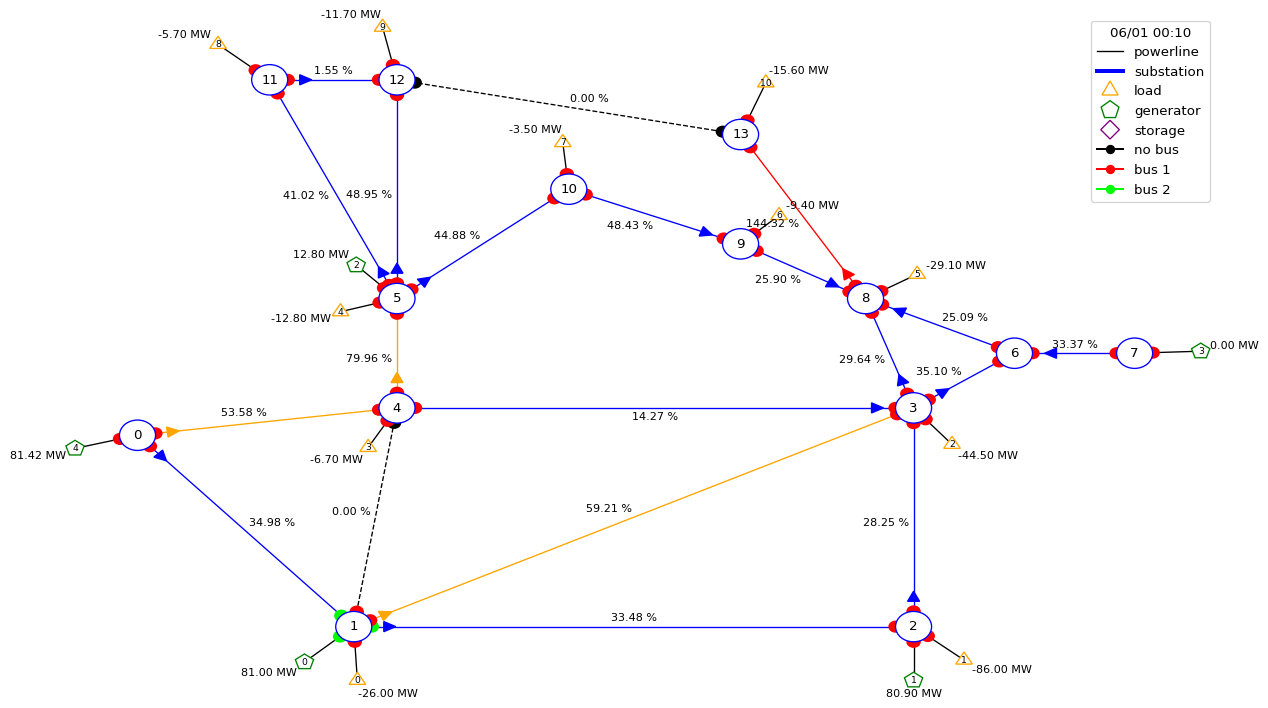

In [15]:
from grid2op.PlotGrid import PlotMatplot
obs = copy.deepcopy(this_episode.observations[2])
# and change the topology (just to have something to represent)
obs.topo_vect[3:9] = [2,2,1,1,2,1]

plot_helper = PlotMatplot(observation_space=this_episode.observation_space)
fig = plot_helper.plot_obs(obs)

## Synchronizing Observations and Actions

As stated in the documentation, at row i, we can read the observation at time "i" (before he took the action at time "i"), and the action at time "i". This means that at row i of the numpy arrays, we can see what the agent saw at that time and what action he chose from that observation. We have "an agent view".

In case we want to see the impact of an Action (see the action the agent took and the observation from the environment **after** the action has been taken), it is therefore then necessary to:

- look at action i
- look at observation i+1

## Using the dedicated grid2viz framework

Grid2viz is a package that has been developped to help you visualize the behaviour of your agent. This will be detailed in the notebook [7_PlottingCapabilities](7_PlottingCapabilities.ipynb).